# Forecasting Prediction using Facebook's Prophet model

In [2]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm


from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from fbprophet import Prophet

In [3]:
#!conda install -c conda-forge fbprophet -y

In [4]:
#!pip install --upgrade plotly

In [45]:
data = pd.read_csv('../data/train.csv')

In [95]:
data_1_1 = data[data['store'] == 1]
data_1_1 = data_1_1[data_1_1['item'] == 1]
data_1_1 = data_1_1[['date','sales']]
data_1_1 = data_1_1.set_index('date')

## Stationarizing Time Series Data

Differencing is a technique used to remove trends if the series is stationary around a trend.

This is the same differencing process used in the ARIMA model

#### Differencing

In [96]:
first_diff = data_1_1.sales - data_1_1.sales.shift(1)
first_diff = first_diff.dropna()

In [97]:
first_diff = pd.DataFrame(data = {'ds': first_diff.index, 'y': first_diff.values})

In [98]:
cutoff_date = '2017-10-01'

train = first_diff.loc[first_diff.ds < cutoff_date]
test = first_diff.loc[first_diff.ds >= cutoff_date]

In [99]:
train.head()

,ds,y
0,2013-01-02,-2.0
1,2013-01-03,3.0
2,2013-01-04,-1.0
3,2013-01-05,-3.0
4,2013-01-06,2.0


## Facebook's Prophet Model

* Facebook's Prophet is an open-source library designed for making forecasts for univariate time series. In this case the variable we are trying to forecast is the number of sales
* Automatically finds the most optimal hyperparemeters for the model.
* Decomposes the time series into trend, seasonality, and holiday effect

#### How Prophet works

The Prophet procedure is an additive regression model with four main components:

$$y(t) = g(t) + s(t) + h(t)$$

Trend $g(t)$

* $g(t)$ is the trend function. This function models the non-periodic change in the value of the time series.

Seasonality $s(t)$

* $s(t)$ is the seasonality function (weekly and yearly seasonality). This function models the periodic changes.

Holiday $h(t)$

* $h(t)$ is the holiday function. This function models the effects of holidays which occur on potentially irregular schedules over one or more days

The input to Prophet model is always a dataframe with two columns:
* ds - datestamp. In a format expected by pandas.
* y - numeric value. This is the value we want to forecast

Prophet imposes the strict condition that the input columns **must** be named **ds** and **y**

In [100]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zhikaichen/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [101]:
future = model.make_future_dataframe(periods = test.shape[0])
prophet_prediction = model.predict(future)

/Users/zhikaichen/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [112]:
prophet_prediction.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2013-01-02,-0.030314,-7.250485,8.578398,-0.030314,-0.030314,0.638613,0.638613,0.638613,0.686754,0.686754,0.686754,-0.048141,-0.048141,-0.048141,0.0,0.0,0.0,0.608299
2013-01-03,-0.030284,-7.741417,8.507537,-0.030284,-0.030284,0.498984,0.498984,0.498984,0.561630,0.561630,0.561630,-0.062646,-0.062646,-0.062646,0.0,0.0,0.0,0.468700
2013-01-04,-0.030254,-6.974293,9.739338,-0.030254,-0.030254,1.659850,1.659850,1.659850,1.735158,1.735158,1.735158,-0.075307,-0.075307,-0.075307,0.0,0.0,0.0,1.629596
2013-01-05,-0.030224,-6.260049,9.582407,-0.030224,-0.030224,1.661414,1.661414,1.661414,1.747136,1.747136,1.747136,-0.085722,-0.085722,-0.085722,0.0,0.0,0.0,1.631189
2013-01-06,-0.030195,-7.214068,8.658688,-0.030195,-0.030195,0.757997,0.757997,0.757997,0.851565,0.851565,0.851565,-0.093568,-0.093568,-0.093568,0.0,0.0,0.0,0.727802


Prophet returns a large dataframe consisting of many columns. Important columns that we look at are:

* ds - the datestamp
* yhat - the forecasted value 
* yhat_lower - lower bound of the forecast
* yhat_upper - upper bound of the forecast

In [102]:
prophet_prediction = prophet_prediction.set_index('ds')
test = test.set_index('ds')
test = test.y
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= cutoff_date]

We will be using The Mean Absolute Error (MAE) to evaluate the performance of our model.

$$
\frac{1}{n}\,\sum_{i=1}^n{f_t - d_t}
$$

where: 
* $f_t$ is the forecasted demand
* $d_t$ is the actual demand
* $n$ is the number of historical periods where you have both a forecast and a demand

In [103]:
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))

Prophet MAE =  5.143516561234938


In [110]:
test.index = pd.to_datetime(test.index)
prophet_future.index = pd.to_datetime(prophet_future.index)

Text(0.5, 1.0, 'SARIMAX Prediction')

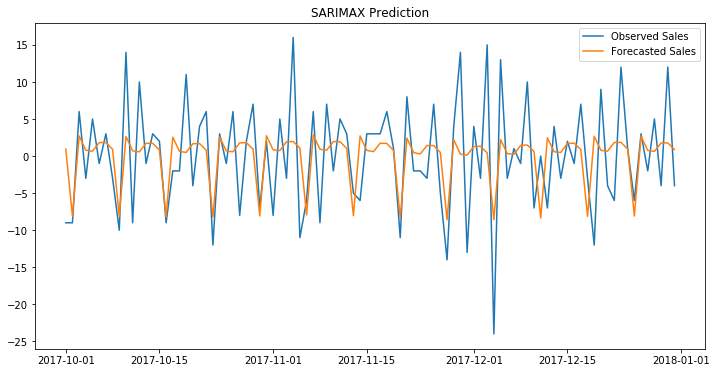

In [111]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test[cutoff_date:], label = 'Observed Sales')
forecast = plt.plot(prophet_future, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("SARIMAX Prediction")